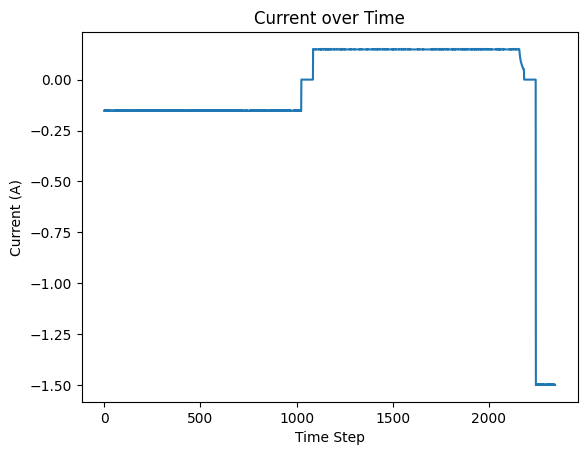

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, BatchNormalization, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Load the data from the CSV file
data = pd.read_csv('/content/0_deg.csv')

# Extract the current values
current = data["Current"]

# Plot the data
plt.plot(current)
plt.title('Current over Time')
plt.xlabel('Time Step')
plt.ylabel('Current (A)')
plt.show()


In [ ]:
# Perform ADF test for stationarity
result = adfuller(current)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_current = scaler.fit_transform(np.array(current).reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_current) * 0.7)
train_data, test_data = scaled_current[:train_size], scaled_current[train_size:]


ADF Statistic: -0.23982938172572013
p-value: 0.9336045282505752
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [ ]:
# Define sequence length
seq_length = 50

# Create sequences for training and testing
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [ ]:
# Build the BiLSTM model with regularization
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(seq_length, 1)))
model.add(Dropout(0.2))  # Add dropout regularization
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))  # Add dropout regularization
model.add(Dense(1))

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
print(model.summary())
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 50, 100)          20800     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 50, 100)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 81,301
Trainable params: 81,301
Non-trai

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


Epoch 1/10
50/50 [==============================] - 16s 172ms/step - loss: 0.0416 - mae: 0.1321 - rmse: 0.2040 - val_loss: 0.0198 - val_mae: 0.0500 - val_rmse: 0.1406
Epoch 2/10
50/50 [==============================] - 6s 112ms/step - loss: 0.0053 - mae: 0.0592 - rmse: 0.0731 - val_loss: 0.0189 - val_mae: 0.0584 - val_rmse: 0.1376
Epoch 3/10
50/50 [==============================] - 7s 140ms/step - loss: 0.0042 - mae: 0.0509 - rmse: 0.0647 - val_loss: 0.0188 - val_mae: 0.0573 - val_rmse: 0.1371
Epoch 4/10
50/50 [==============================] - 6s 113ms/step - loss: 0.0040 - mae: 0.0502 - rmse: 0.0629 - val_loss: 0.0191 - val_mae: 0.0471 - val_rmse: 0.1383
Epoch 5/10
50/50 [==============================] - 7s 141ms/step - loss: 0.0036 - mae: 0.0475 - rmse: 0.0598 - val_loss: 0.0193 - val_mae: 0.0454 - val_rmse: 0.1389
Epoch 6/10
50/50 [==============================] - 6s 110ms/step - loss: 0.0033 - mae: 0.0454 - rmse: 0.0577 - val_loss: 0.0192 - val_mae: 0.0436 - val_rmse: 0.1387
Epo

In [ ]:
# Make predictions on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


21/21 [==============================] - 1s 26ms/step


In [ ]:
# Calculate MSE and MAE for train and test data
train_mse = mean_squared_error(scaler.inverse_transform(y_train[1:]), train_predict[1:])
test_mse = mean_squared_error(scaler.inverse_transform(y_test[1:]), test_predict[1:])
train_mae = mean_absolute_error(scaler.inverse_transform(y_train[1:]), train_predict[1:])
test_mae = mean_absolute_error(scaler.inverse_transform(y_test[1:]), test_predict[1:])

print('Train MSE:', train_mse)
print('Test MSE:', test_mse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)


Train MSE: 0.00039189864581586656
Test MSE: 0.05433802026389527
Train MAE: 0.010500305718461824
Test MAE: 0.07384000973119757


In [ ]:
# Save test predictions to a CSV file
test_predictions_df = pd.DataFrame({'Test Ground Truth': scaler.inverse_transform(y_test[1:]).flatten(),
                                    'Test Predictions': test_predict[1:].flatten()})
test_predictions_df.to_csv('test_predictions_SoC_milli_0deg.csv', index=False)

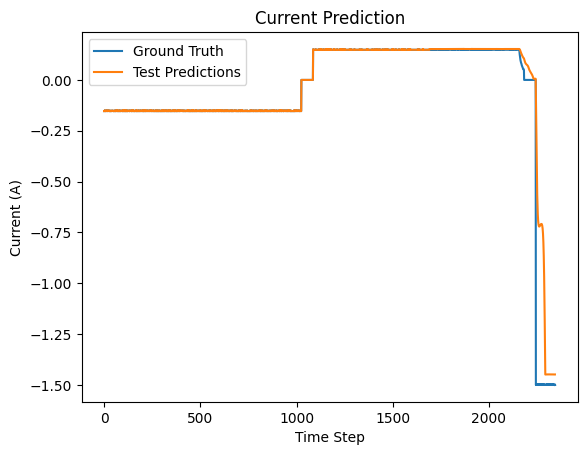

In [ ]:
# Plot the ground truth and predicted current values
plt.plot(current.values, label='Ground Truth')
plt.plot(np.concatenate([current[:train_size + seq_length].values.reshape(-1), test_predict[1:].reshape(-1)]), label='Test Predictions')
plt.title('Current Prediction')
plt.xlabel('Time Step')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 43ms/step


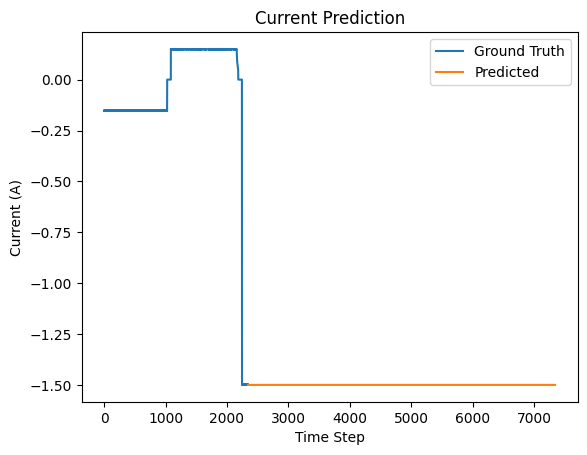

In [ ]:
# Define the number of predictions
pred_length = 5000

# Make predictions for the next 50 current values
last_sequence = np.copy(test_data[-seq_length:])
predicted_values = []
for _ in range(pred_length):
    prediction = model.predict(last_sequence.reshape(1, seq_length, 1))
    predicted_values.append(prediction[0])
    last_sequence = np.concatenate((last_sequence[1:], prediction))

# Transform predicted values back to the original scale
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

# Plot the ground truth and predicted values
plt.plot(current.values, label='Ground Truth')
plt.plot(np.arange(len(current), len(current) + pred_length), predicted_values, label='Predicted')
plt.title('Current Prediction')
plt.xlabel('Time Step')
plt.ylabel('Current (A)')
plt.legend()
plt.show()
